# Import libraries

In [5]:
import xarray as xr
import numpy as np
from sklearn.model_selection import train_test_split
import os
import shutil
import matplotlib.pyplot as plt

# Set file paths

In [6]:
# Load all files
root_dir = r"D:\Ghana\Merged_files_IMERG_SEVIRI\Condition_set_0.02_20_all" #File path to your data

# List of NetCDF files
# Traverse through all subdirectories and files in the given path
files_path = []
for root, dirs, files in os.walk(root_dir):
    for file in files:
        if file.endswith(".hdf5"):
            files_path.append(os.path.join(root, file))


# Output directories
output_dirs = {
    "train": r"Z:\cluster_projects\ro\1149_10\earthformer-multisource-to-inca\data_condition_0.02_20_no_vis\train",
    "val": r"Z:\cluster_projects\ro\1149_10\earthformer-multisource-to-inca\data_condition_0.02_20_no_vis\val",
    "test": r"Z:\cluster_projects\ro\1149_10\earthformer-multisource-to-inca\data_condition_0.02_20_no_vis\test"
}

# Retrieve data from your files

In [8]:
imerg_means = []

# Iterate over each file and process separately
for file in files_path:
    # Step 1: Load the file
    data = xr.open_dataset(file)['IMERG'][:] 

    # Step 2: Calculate mean precipitation for each frame
    imerg_mean = np.mean(data, axis=(0, 1, 2)).values  # Single value
    imerg_means.append(imerg_mean)

# Bin the data
The spatial average of rainfall is binned. 

bin count before merging [np.int64(1765), np.int64(1931), np.int64(1538), np.int64(904), np.int64(632), np.int64(430), np.int64(299), np.int64(194), np.int64(139), np.int64(81), np.int64(55), np.int64(22), np.int64(21), np.int64(20), np.int64(18), np.int64(14), np.int64(5), np.int64(8), np.int64(7), np.int64(1)]
20
19
bin count after merging [np.int64(1765), np.int64(1931), np.int64(1538), np.int64(904), np.int64(632), np.int64(430), np.int64(299), np.int64(194), np.int64(139), np.int64(81), np.int64(55), np.int64(22), np.int64(21), np.int64(20), np.int64(18), np.int64(14), np.int64(5), np.int64(8), np.int64(8)]


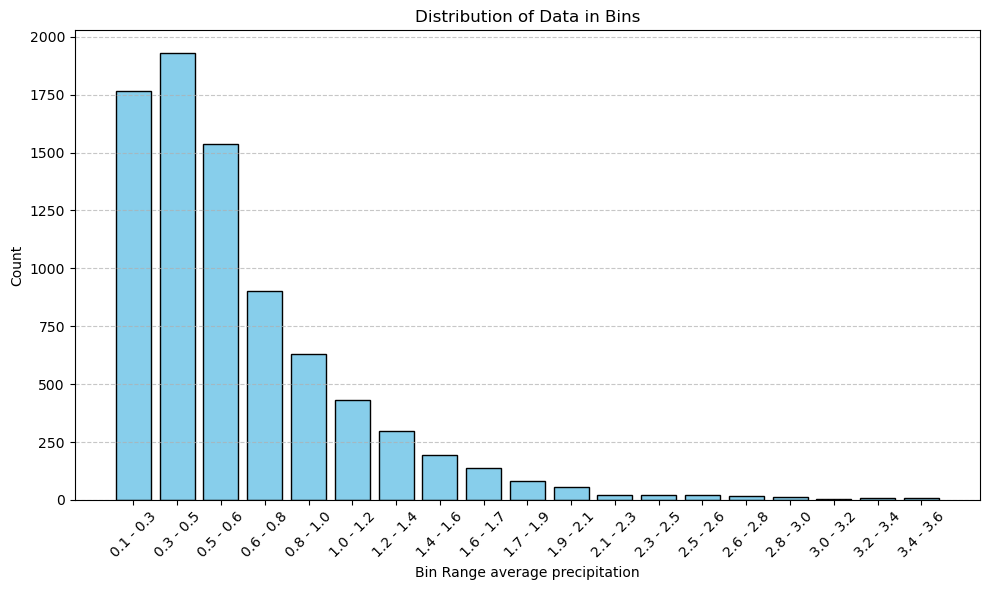

In [10]:
# Create bins and stratify
bins = np.linspace(np.min(imerg_means), np.max(imerg_means), num=20)  # Create bins)

# Digitize the data into bins
bin_indices = np.digitize(imerg_means, bins)

bin_counts = [np.sum(bin_indices == i) for i in range(1, len(bins) + 1)]
print('bin count before merging', bin_counts)

# Ensure each bin has at least `min_samples` samples
min_samples = 5

# Repeat until no bin has fewer than `min_samples` samples
while True:
    # Identify bins with fewer than `min_samples` samples
    bins_with_few_samples = [bin_idx for bin_idx in np.unique(bin_indices)
                             if np.sum(bin_indices == bin_idx) < min_samples]

    # Break if all bins meet the minimum sample requirement
    if not bins_with_few_samples:
        break

    # Merge sparse bins into their nearest neighbor bin
    for bin_idx in bins_with_few_samples[::-1]:
        print(bin_idx)
        # Find the neighboring bin to merge into (smaller bin, or larger if the smallest bin)
        if bin_idx > 1:  # Check if there's a smaller bin to merge into
            merge_target = bin_idx - 1
            print(merge_target)
        else:  # Otherwise, merge into the next larger bin
            merge_target = bin_idx + 1
        
        # Update bin_indices: Assign the sparse bin to the merge target
        bin_indices[bin_indices == bin_idx] = merge_target

        # recalculate bins with fewer than `min_samples` samples
        bins_with_few_samples = [bin_idx for bin_idx in np.unique(bin_indices)
                                 if np.sum(bin_indices == bin_idx) < min_samples]

        if not bins_with_few_samples:
            break

# Count the number of samples in each bin
bin_counts = [np.sum(bin_indices == i) for i in range(1, len(bins))]

print('bin count after merging', bin_counts)

# Plot the histogram of bins
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(bins)), bin_counts, width=0.8, align='center', color='skyblue', edgecolor='k')
plt.xticks(range(1, len(bins)), [f"{bins[i-1]:.1f} - {bins[i]:.1f}" for i in range(1, len(bins))], rotation=45)
plt.xlabel("Bin Range average precipitation")
plt.ylabel("Count")
plt.title("Distribution of Data in Bins")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
# Show the plot
plt.show()


# Make a stratified split of each bin

In [11]:
# Step 4: Stratified splitting
train_idx, temp_idx = train_test_split(
    np.arange(len(files_path)),
    test_size=0.3,
    stratify=bin_indices,
    random_state=42
)
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.3,
    stratify=bin_indices[temp_idx],
    random_state=42
)

train_files = [files_path[i] for i in train_idx]  
val_files = [files_path[i] for i in val_idx]
test_files = [files_path[i] for i in test_idx]

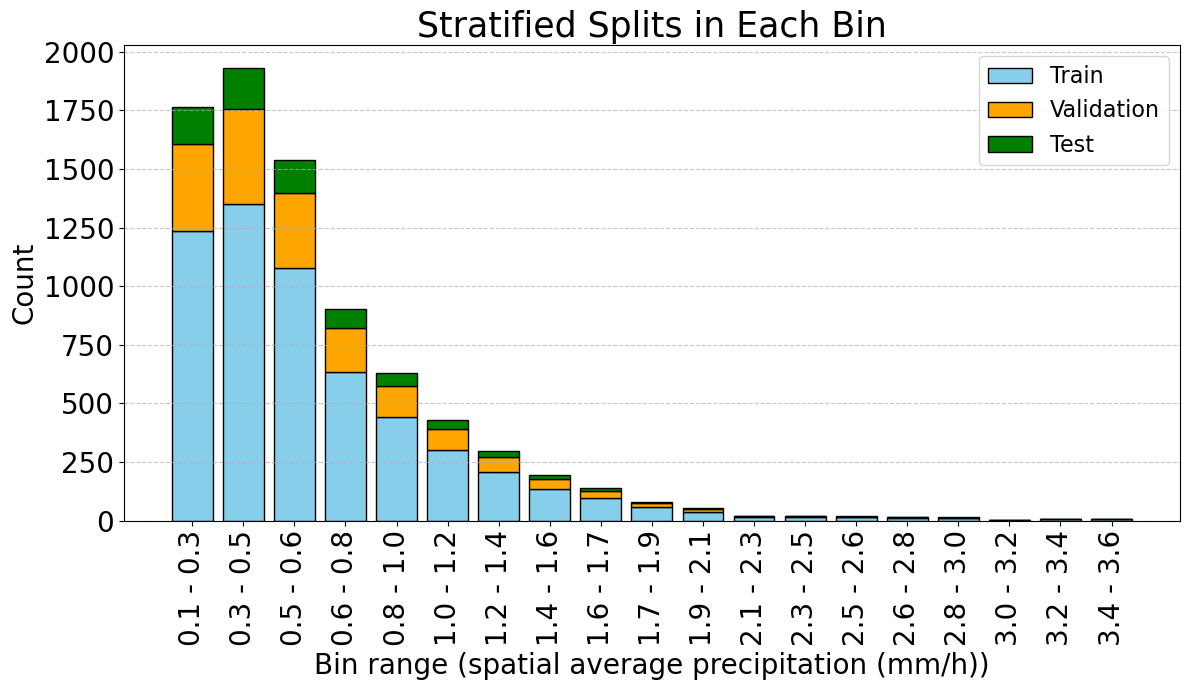

In [24]:
# Calculate counts for each dataset type within each bin
train_counts = [np.sum(bin_indices[train_idx] == i) for i in range(1, len(bins))]
val_counts = [np.sum(bin_indices[val_idx] == i) for i in range(1, len(bins))]
test_counts = [np.sum(bin_indices[test_idx] == i) for i in range(1, len(bins))]

# Create a stacked bar plot
plt.figure(figsize=(12, 7))
bar_width = 0.8

# Plot train, validation, and test counts for each bin
x = range(1, len(bins))
plt.bar(x, train_counts, width=bar_width, color='skyblue', edgecolor='k', label='Train')
plt.bar(x, val_counts, width=bar_width, color='orange', edgecolor='k', bottom=train_counts, label='Validation')
plt.bar(x, test_counts, width=bar_width, color='green', edgecolor='k', 
        bottom=np.array(train_counts) + np.array(val_counts), label='Test')

# Add labels and title
plt.xticks(x, [f"{bins[i-1]:.1f} - {bins[i]:.1f}" for i in range(1, len(bins))], fontsize = 20, rotation=90)
plt.yticks(fontsize = 20)
plt.xlabel("Bin range (spatial average precipitation (mm/h))", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.title("Stratified Splits in Each Bin", fontsize = 25)
plt.legend(fontsize = 16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Stratified_splits_in_each_bin.png', bbox_inches = 'tight', dpi = 300)

# Show the plot
plt.show()


# Write the files

The splitted data is written to to the correct directory for training, validation and testing

In [ ]:
# Create directories if they don't exist
for dir_path in output_dirs.values():
    os.makedirs(dir_path, exist_ok=True)

# Function to copy files to the respective directory
def copy_files(indices, source_paths, destination_dir):
    error_files = []
    try:
        for idx in indices:
            src = source_paths[idx]
            dst = os.path.join(destination_dir, os.path.basename(src))  # Keep original filename
            if not os.path.exists(dst):
                shutil.copy(src, dst)
                print(f"Copied {src} to {dst}")

    except:
        error_files.append(source_paths[idx])

    return error_files

# Copy files to the directories
error_files_train = copy_files(train_idx, files_path, output_dirs["train"])
error_files_val = copy_files(val_idx, files_path, output_dirs["val"])
error_files_test = copy_files(test_idx, files_path, output_dirs["test"])


print("Files successfully copied!")